In [28]:
#import all the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from transformers import pipeline
from googletrans import Translator
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix


In [29]:
df = pd.read_csv('test_4.csv')

In [30]:
df.shape

(1000, 6)

In [31]:
df.describe

<bound method NDFrame.describe of                                          DealerComment  \
0    * ******************************SKARGA********...   
1    ******************************REKL************...   
2    ******************************Klgomål*********...   
3    ******************************REKL************...   
4    ******************************INCIDENT********...   
..                                                 ...   
995  * ******************************SKARGA********...   
996  ******************************SICAYET*********...   
997  * ******************************SKARGA********...   
998  * ******************************REKL**********...   
999  * ******************************TIPO_DANNO****...   

                     Component                Failure     DefectivePart  \
0                     BEARINGS                  NOISE    WHEEL BEARINGS   
1                  RAIN SENSOR   INCORRECT ADJUSTMENT            SENSOR   
2                    EGR VALVE            WA

In [32]:
#dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DealerComment  1000 non-null   object 
 1   Component      1000 non-null   object 
 2   Failure        1000 non-null   object 
 3   DefectivePart  1000 non-null   object 
 4   PartsReplaced  1000 non-null   float64
 5   Cost           1000 non-null   float64
dtypes: float64(2), object(4)
memory usage: 47.0+ KB


In [33]:
#to check columns
df.columns

Index(['DealerComment', 'Component', 'Failure', 'DefectivePart',
       'PartsReplaced', 'Cost'],
      dtype='object')

In [34]:
#to check the first five rows
df.head()

,DealerComment,Component,Failure,DefectivePart,PartsReplaced,Cost
0,* ******************************SKARGA********...,BEARINGS,NOISE,WHEEL BEARINGS,5.0,299.776842
1,******************************REKL************...,RAIN SENSOR,INCORRECT ADJUSTMENT,SENSOR,1.0,67.360000
2,******************************Klgomål*********...,EGR VALVE,WATER LEAKS,EGR VALVE,1.0,1106.880000
3,******************************REKL************...,BRAKE CALIPER,BLOCKAGE,BRAKE SADDLE,1.5,443.450000
4,******************************INCIDENT********...,SLEEVES,BREAK,RUBBER SLEEVE,1.0,153.130000


In [35]:
#tranlating the english column in dealer_comment
translator = Translator()
def translate_text(text):
    return translator.translate(text, dest='en').text

In [36]:
df['Translated_DealerComment'] = df['DealerComment'].apply(translate_text)

In [37]:
df['DealerComment'] = df['DealerComment'].str.replace('*', '', regex=False).str.replace('_', ' ', regex=False)

In [38]:
df['Translated_DealerComment'] = df['Translated_DealerComment'].str.replace('*', '', regex=False).str.replace('_', ' ', regex=False)

In [39]:
df.head()

,DealerComment,Component,Failure,DefectivePart,PartsReplaced,Cost,Translated_DealerComment
0,SKARGA HALAS Z PRZODU POJAZDU PODCZAS JAZDY ...,BEARINGS,NOISE,WHEEL BEARINGS,5.0,299.776842,COMPLAINT NOISE FROM THE FRONT OF THE VEHICL...
1,REKL Fehler Regensenor GRUND Regensensor defek...,RAIN SENSOR,INCORRECT ADJUSTMENT,SENSOR,1.0,67.360000,REKL Rain sensor error REASON Rain sensor de...
2,Klgomål FELSÖKNING: BILEN DRAR KYLARVÄTSKA Ors...,EGR VALVE,WATER LEAKS,EGR VALVE,1.0,1106.880000,Goals TROUBLESHOOTING: THE CAR DRAWS COOLANT ...
3,REKL Vorderachsbremse rechts wird heiss. GRUND...,BRAKE CALIPER,BLOCKAGE,BRAKE SADDLE,1.5,443.450000,REKL Front axle brake on the right is getting...
4,INCIDENT PERTE PUISSANCE \nBRUIT A L ACCELERAT...,SLEEVES,BREAK,RUBBER SLEEVE,1.0,153.130000,INCIDENT POWER LOSS \nNOISE DURING ACCELERATI...


In [40]:
components = df['Component'].dropna().unique().tolist()
defective_parts = df['DefectivePart'].dropna().unique().tolist()
failure_types = df['Failure'].dropna().unique().tolist()
parts_replaced = df['PartsReplaced'].dropna().unique().tolist()
cost_occured = df['Cost'].dropna().unique().tolist()

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Create a custom entity ruler
ruler = nlp.add_pipe("entity_ruler", before="ner")

def create_patterns(label, values):
    return [{"label": label, "pattern": [{"LOWER": str(value).lower()}]} for value in values]

# Create patterns for each type of information
component_patterns = create_patterns("DEFECTIVE_COMPONENT", components)
defective_part_patterns = create_patterns("DEFECTIVE_PART", defective_parts)
failure_patterns = create_patterns("FAILURE_TYPE", failure_types)

# Convert parts_replaced to strings and filter out non-string values
parts_replaced = [str(part) for part in parts_replaced if isinstance(part, (int, float)) or isinstance(part, str)]
No_of_parts = create_patterns("NUM_PARTS_REPLACED", parts_replaced)

# Convert cost_occured to strings and filter out non-string values
cost_occured = [str(cost) for cost in cost_occured if isinstance(cost, (int, float)) or isinstance(cost, str)]
Total_Cost = create_patterns("COST", cost_occured)

# Add patterns for cause of failure types
cause_of_failure_patterns = create_patterns("CAUSE_OF_FAILURE", ["material issue", "human error", "design flaw"])

# Add all patterns to the entity ruler
ruler.add_patterns(component_patterns)
ruler.add_patterns(defective_part_patterns)
ruler.add_patterns(failure_patterns)
ruler.add_patterns(No_of_parts)
ruler.add_patterns(Total_Cost)
ruler.add_patterns(cause_of_failure_patterns)

# Example function to extract entities
def extract_entities(text):
    doc = nlp(text)
    extracted_info = {ent.label_: ent.text for ent in doc.ents}
    return extracted_info

In [41]:
# Initialize the zero-shot classification using pipeline
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="Jiva/xlm-roberta-large-it-mnli")
cause_labels = ['Human Error','Design Flaws','Material Issue']


In [42]:
def classify_cause(text):
    result = classifier(text, cause_labels)
    return result['labels'][0]

In [43]:
df['Cause_of_Failure'] = df['Translated_DealerComment'].apply(classify_cause)

In [44]:
for cause in cause_labels:
    df[cause] = df['Cause_of_Failure'].apply(lambda x: 1 if x == cause else 0)
    print(cause)

Human Error
Design Flaws
Material Issue


In [45]:
print(cause_labels)

['Human Error', 'Design Flaws', 'Material Issue']


In [46]:
cause_distribution = df['Cause_of_Failure'].value_counts(normalize=True)
print("\nDistribution of Components_Failure:")
print(cause_distribution)


Distribution of Components_Failure:
Cause_of_Failure
Material Issue    0.646
Design Flaws      0.342
Human Error       0.012
Name: proportion, dtype: float64


In [47]:
df.to_csv("failure_results.csv",index=False)

In [63]:
df = pd.read_csv("failure_results.csv")

In [49]:
def extract_features(row):
    dealer_comment = row['Translated_DealerComment']
    extracted_entities = extract_entities(dealer_comment)
    cause = classify_cause(dealer_comment)

    return {
        "Defective Component": extracted_entities.get("DEFECTIVE_COMPONENT", "N/A"),
        "Defective Part": extracted_entities.get("DEFECTIVE_PART", "N/A"),
        "Type of Failure": extracted_entities.get("FAILURE_TYPE", "N/A"),
        "Number of Parts Replaced": extracted_entities.get("NUM_PARTS_REPLACED", "N/A"),
        "Total Cost": extracted_entities.get("COST", "N/A"),
        "Cause of Failure": cause
    }

# Apply the function to the dataset
data_features = df.apply(extract_features, axis=1)

# Convert to DataFrame for further analysis
features_df = pd.DataFrame(data_features.tolist())
print(features_df.head())

  Defective Component Defective Part Type of Failure Number of Parts Replaced  \
0                 N/A            N/A      ADJUSTMENT                      N/A   
1              sensor         Sensor             N/A                      N/A   
2               HOSES              .             N/A                      N/A   
3                 N/A              .             N/A                      N/A   
4                 N/A           HOSE           NOISE                      N/A   

  Total Cost Cause of Failure  
0        N/A   Material Issue  
1        N/A   Material Issue  
2        N/A   Material Issue  
3        N/A   Material Issue  
4        N/A   Material Issue  


In [50]:
features_df

,Defective Component,Defective Part,Type of Failure,Number of Parts Replaced,Total Cost,Cause of Failure
0,N/A,N/A,ADJUSTMENT,N/A,N/A,Material Issue
1,sensor,Sensor,N/A,N/A,N/A,Material Issue
2,HOSES,.,N/A,N/A,N/A,Material Issue
3,N/A,.,N/A,N/A,N/A,Material Issue
4,N/A,HOSE,NOISE,N/A,N/A,Material Issue
...,...,...,...,...,...,...
995,ENGINE,HOSE,NOISE,N/A,N/A,Material Issue
996,N/A,alternator,N/A,N/A,N/A,Material Issue
997,cables,socket,N/A,N/A,N/A,Material Issue
998,N/A,N/A,N/A,N/A,N/A,Material Issue


In [52]:
features_df.to_csv('final_test.csv',index=False)

In [53]:
features_df = pd.read_csv('final_test.csv')

In [61]:
features_df

,Defective Component,Defective Part,Type of Failure,Number of Parts Replaced,Total Cost,Cause of Failure
0,NaN,NaN,ADJUSTMENT,NaN,NaN,Material Issue
1,sensor,Sensor,NaN,NaN,NaN,Material Issue
2,HOSES,.,NaN,NaN,NaN,Material Issue
3,NaN,.,NaN,NaN,NaN,Material Issue
4,NaN,HOSE,NOISE,NaN,NaN,Material Issue
...,...,...,...,...,...,...
995,ENGINE,HOSE,NOISE,NaN,NaN,Material Issue
996,NaN,alternator,NaN,NaN,NaN,Material Issue
997,cables,socket,NaN,NaN,NaN,Material Issue
998,NaN,NaN,NaN,NaN,NaN,Material Issue


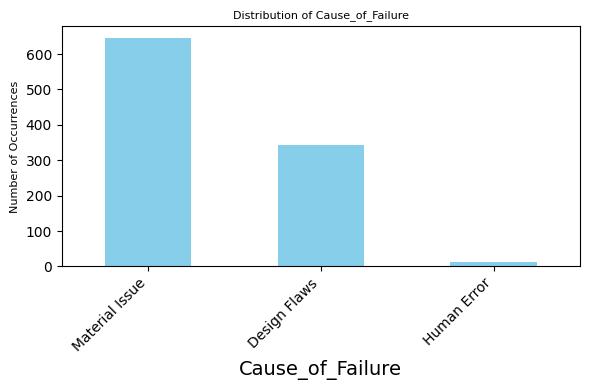

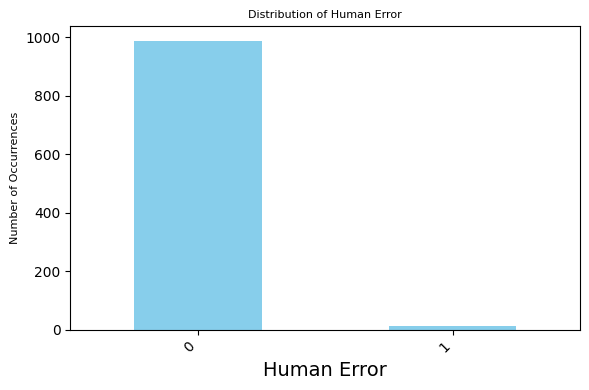

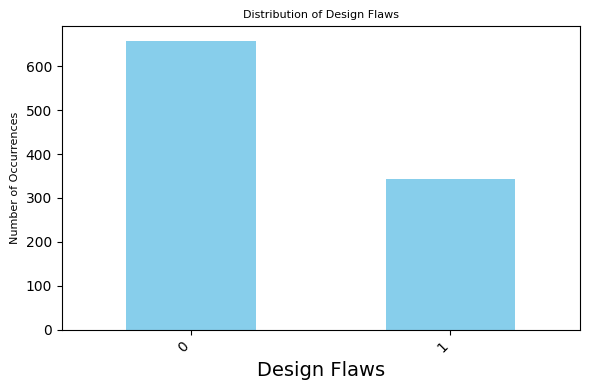

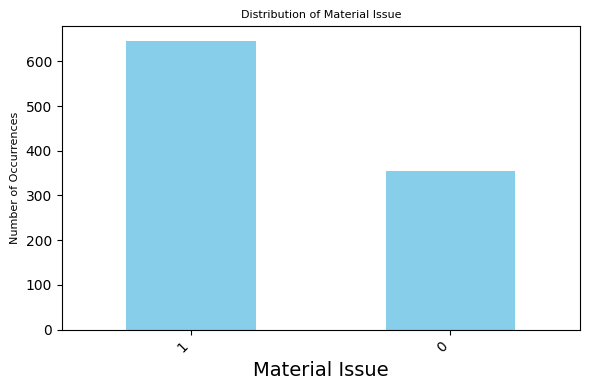

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'failure_results.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# List of columns to analyze
analyze = ['Cause_of_Failure','Human Error','Design Flaws','Material Issue']

# Loop through each column and plot its distribution
for column in analyze:
    plt.figure(figsize=(6, 4))
    # Count occurrences of each value in the column
    value_counts = df[column].value_counts()
    
    # Plot the distribution
    value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}', fontsize=8)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Number of Occurrences', fontsize=8)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show each plot
    plt.show()
